## Table Of Contents
<font size=3rem>
    
0 -**[ GPU SETTINGS](#GPU-SETTINGS)**<br>
1 -**[ BUSINESS UNDERSTANDING](#BUSINESS-UNDERSTANDING)**<br>
2 -**[ DATA UNDERSTANDING](#DATA-UNDERSTANDING)**<br>
3 -**[ DATA PREPARATION](#DATA-PREPARATION)**<br>
4 -**[ MODELING](#MODELING)**<br>
5 -**[ EVALUATION](#EVALUATION)<br>**
</font>
___

# BUSINESS UNDERSTANDING

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

- Pneumonia Chest Xray Image Classification
    - Objective
        - To attain the highest level of accuracy and repeatability to detect cases of pneumonia while minimizing false positives/negatives.
    - Priority
         - (1) Do not want to tell a sick person they are healthy
            
         - (2) Accurately identify pneumonia
         - (3) Avoid telling healthy person they are sick

## Import Tools

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
import cv2
import random
import datetime
from tensorflow.python.client import device_lib
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.densenet import DenseNet201

Using TensorFlow backend.


In [2]:
notebook_original_start = datetime.datetime.now()

# GPU SETTINGS

In [3]:
# https://github.com/jeffheaton/present/blob/master/youtube/gpu/keras-dual-gpu.ipynb
# https://www.youtube.com/watch?v=HCLmM1PyDIs

# List of Local Devices
devices = device_lib.list_local_devices()

# Calculate size of device
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

# Data in Devices, Type, Name, Abrv, Memory
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 2070 SUPER || GPU || 5.8 GiB


In [4]:
print("Number of GPU's Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Number of GPU's Available:  1


## FUNCTIONS

In [5]:
def get_num_pixels(pixel_path):
    '''
    Gets width and height of image
    :param pixel_path: String
    :return width, height: Tuple of Int
    '''
    
    width, height = Image.open(pixel_path).size
    return width, height

In [6]:
def get_image_pixels_and_paths(path):
    '''
    Joins the classes of called picture pixel count for total of called class
    :param path: String
    :return None: prints out pixel dimensions
    '''
    
    # Iterate through 5 entries to print number of pixels from image
    for path, subdirs, files in os.walk(path):
        for index, name in enumerate(files):
            image_path = os.path.join(path,name)
            print(get_num_pixels(image_path))
            if index >= 4:
                break

In [7]:
# Code Sourced from Learn.Co, modified for this project
# https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
def visualize_training_results(results):
    '''
    Renders out metric results into graphs
    :param results: tensorflow.python.keras.callbacks.History
    :return None: print out graphs
    '''
    # Assign variable for model history results
    history = results.history
    
    # Loss metric
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['loss','val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Accuracy metric
    plt.figure()
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['accuracy','val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # Precision metric
    plt.figure()
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    plt.legend(['precision','val_precision'])
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()
    
    # Recall metric
    plt.figure()
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    plt.legend(['recall','val_recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

# DATA UNDERSTANDING

In [9]:
#Home Directory
home_path = r'C:\Users\c_fre\Learn.co\Module_4_Project\Image-Classification\chest_xray'

#Train Directory
train_path = os.path.join(home_path,'train')

#Validation Directory
val_path = os.path.join(home_path,'val')

#Test Directory
test_path = os.path.join(home_path,'test')

#Train Subdirectories
normal_train_path = os.path.join(train_path,'NORMAL')

pneumonia_train_path = os.path.join(train_path,'PNEUMONIA')

#Validation Subdirectories
normal_val_path = os.path.join(val_path,'NORMAL')

pneumonia_val_path = os.path.join(val_path,'PNEUMONIA')

#Test Subdirectories

normal_test_path = os.path.join(test_path,'NORMAL')

pneumonia_test_path = os.path.join(test_path,'PNEUMONIA')

In [10]:
#Print to Verify Directory Pathways
print('Directory Contents:',os.listdir(home_path))
print('train Contents:',os.listdir(train_path))
print('val Contents:',os.listdir(val_path))
print('test Contents:',os.listdir(test_path))

Directory Contents: ['test', 'train', 'val']
train Contents: ['NORMAL', 'PNEUMONIA']
val Contents: ['NORMAL', 'PNEUMONIA']
test Contents: ['NORMAL', 'PNEUMONIA']


In [11]:
#Cases in Training Sets
print("Number of cases in Training:",len(os.listdir(normal_train_path)) +len(os.listdir(pneumonia_train_path)))

#Pneumonia Cases in Training
print("Number of Pneumonia cases in Training:",len(os.listdir(pneumonia_train_path)))

#Normal Cases in Training
print("Number of Normal cases in Training:",len(os.listdir(normal_train_path)))

Number of cases in Training: 2218
Number of Pneumonia cases in Training: 1109
Number of Normal cases in Training: 1109


In [12]:
# Cases in Validation Sets
print("Number of cases in Validation:",len(os.listdir(normal_val_path)) +len(os.listdir(pneumonia_val_path)))

# Pneumonia Cases in Validation
print("Number of Pneumonia cases in Validation:",len(os.listdir(pneumonia_val_path)))

# Normal Cases in Validation
print("Number of Normal cases in Validation:",len(os.listdir(normal_val_path)))

Number of cases in Validation: 474
Number of Pneumonia cases in Validation: 237
Number of Normal cases in Validation: 237


In [13]:
#Cases in Test Sets
print("Number of cases in Test:",len(os.listdir(normal_test_path)) +len(os.listdir(pneumonia_test_path)))

#Pneumonia Cases in Test
print("Number of Pneumonia cases in Test:",len(os.listdir(pneumonia_test_path)))

#Normal cases in Test
print("Number of Normal cases in Test:",len(os.listdir(normal_test_path)))

Number of cases in Test: 474
Number of Pneumonia cases in Test: 237
Number of Normal cases in Test: 237


In [14]:
# #Total number of Normal Cases
print("Total number of Normal cases:",
      len(os.listdir(normal_test_path))+
      len(os.listdir(normal_train_path))+
      len(os.listdir(normal_val_path)))

#Total number of Pneumonia Cases
print("Total number of Pneumonia cases:",
      len(os.listdir(pneumonia_test_path))+
      len(os.listdir(pneumonia_train_path))+
      len(os.listdir(pneumonia_val_path)))

Total number of Normal cases: 1583
Total number of Pneumonia cases: 1583


In [15]:
# Validation Pixel Size
get_image_pixels_and_paths(val_path)

(1214, 662)
(1570, 1164)
(1550, 1033)
(1638, 1323)
(1782, 1434)
(2048, 1656)
(944, 536)
(920, 568)
(848, 632)
(856, 536)


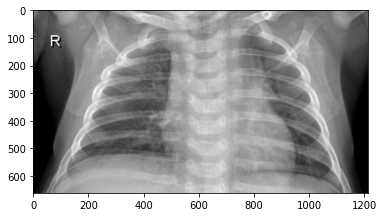

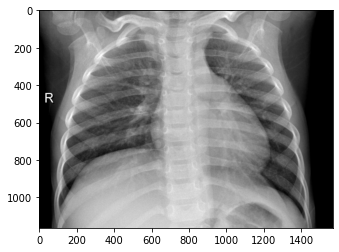

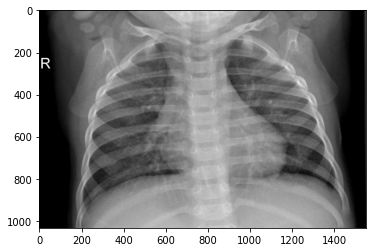

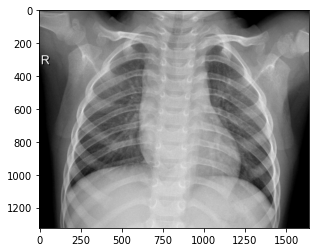

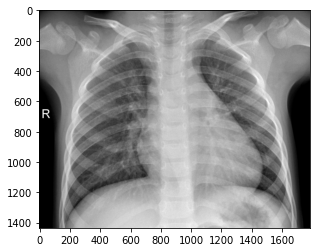

In [16]:
# Display all images in Normal Validatoin pathway
normal_val_images_display = os.listdir(normal_val_path)[:5]
for image_name in normal_val_images_display:
    image_path = os.path.join(normal_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

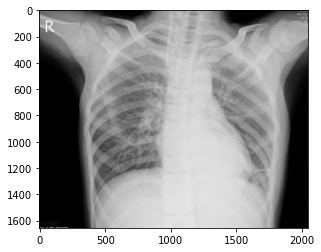

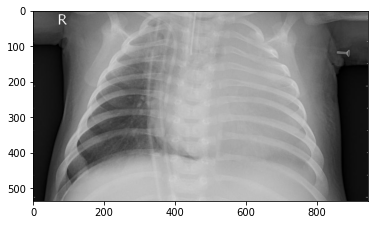

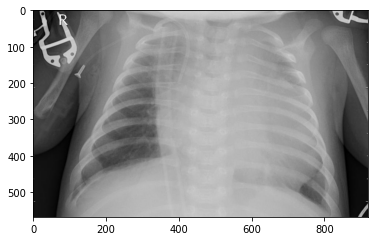

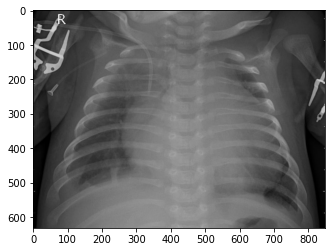

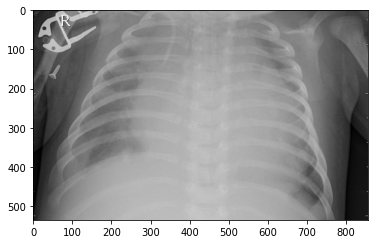

In [17]:
# Display all images in Pneumonia validation pathway
pneumonia_val_image_display = os.listdir(pneumonia_val_path)[:5]
for image_name in pneumonia_val_image_display:
    image_path = os.path.join(pneumonia_val_path, image_name)
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.show()

# DATA PREPARATION

In [18]:
batch_size = 64
img_width, img_height = 200,200

In [19]:
# Augmentation
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale=1 / 255.0)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [20]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)
valid_generator = val_datagen.flow_from_directory(
    directory=val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_width, img_height),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    seed=7539541
)

Found 2218 images belonging to 2 classes.
Found 474 images belonging to 2 classes.
Found 474 images belonging to 2 classes.


# MODELING

## Multi Layer Perceptron

In [21]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [22]:
mlp_model = keras.Sequential()

In [23]:
mlp_model.add(keras.layers.Flatten())

In [24]:
mlp_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [25]:
mlp_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [26]:
mlp_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [27]:
mlp_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [28]:
mlp_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [29]:
mlp_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [30]:
mlp_history = mlp_model.fit(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                            validation_steps = valid_generator.n//valid_generator.batch_size,
                            epochs=10)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 35s 1s/step - loss: 1.5454 - accuracy: 0.6309 - precision: 0.6480 - recall: 0.5702 - val_loss: 0.6211 - val_accuracy: 0.5759 - val_precision: 0.9750 - val_recall: 0.1711
Epoch 2/10
34/34 [==============================] - 32s 934ms/step - loss: 0.5308 - accuracy: 0.7201 - precision: 0.7148 - recall: 0.7235 - val_loss: 0.6581 - val_accuracy: 0.6696 - val_precision: 0.9872 - val_recall: 0.3438
Epoch 3/10
34/34 [==============================] - 32s 930ms/step - loss: 0.4296 - accuracy: 0.8064 - precision: 0.8163 - recall: 0.7913 - val_loss: 0.3590 - val_accuracy: 0.8371 - val_precision: 0.7786 - val_recall: 0.9420
Epoch 4/10
34/34 [==============================] - 32s 934ms/step - loss: 0.4762 - accuracy: 0.7878 - precision: 0.7919 - recall: 0.7793 - val_loss: 0.3113 - val_accuracy: 0.8728 - val_precision: 0.9418 - val_recall: 0.7946
Epoch 5/10
34/34 [==============================] - 31s 929ms/step - loss: 0.4047 - accuracy: 0.8101 - 

In [31]:
mlp_model.save("MLP_Initial_Model")

INFO:tensorflow:Assets written to: MLP_Initial_Model\assets


In [32]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                7680064   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 7,682,817
Trainable params: 7,682,817
Non-trainable params: 0
______________________________________________

In [33]:
loss, acc, precision, recall = mlp_model.evaluate(test_generator)

8/8 [==============================] - 4s 475ms/step - loss: 0.2532 - accuracy: 0.8966 - precision: 0.8884 - recall: 0.9072


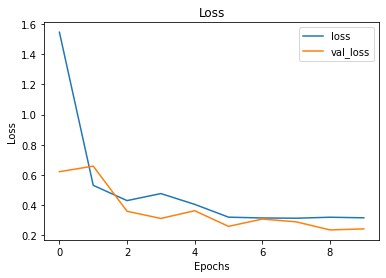

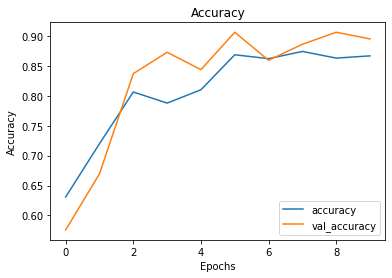

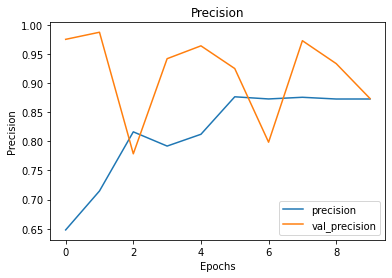

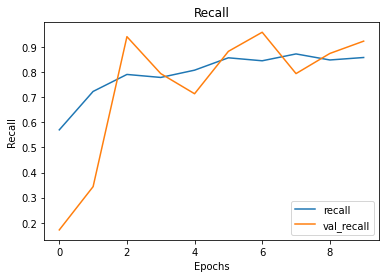

In [34]:
visualize_training_results(mlp_history)

In [35]:
mlp_results_train = mlp_model.evaluate(train_generator)

35/35 [==============================] - 28s 810ms/step - loss: 0.3020 - accuracy: 0.8738 - precision: 0.8335 - recall: 0.9342


In [36]:
mlp_results_test = mlp_model.evaluate(test_generator)

8/8 [==============================] - 3s 415ms/step - loss: 0.2532 - accuracy: 0.8966 - precision: 0.8884 - recall: 0.9072


## CNN Model

In [37]:
#Rationale guided by Tensorflow youtube series
# 1 https://www.youtube.com/watch?v=KNAWp2S3w94&t
# 2 https://www.youtube.com/watch?v=bemDFpNooA8
# 3 https://www.youtube.com/watch?v=x_VrgWTKkiM
# 4 https://www.youtube.com/watch?v=u2TjZzNuly8

In [38]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [39]:
# Sequential: as we want to build layers upon each other
cnn_model = keras.Sequential()

In [40]:
# 2D Convolution Layer over Images, Generate 64 filters and multiply across the image
# Filter Images to highlight features
cnn_model.add(keras.layers.Conv2D(64,
                                  kernel_size=(3,3),
                                  activation='relu',
                                  input_shape=(img_width, img_height, 3)))

In [41]:
# Group images into 2x2, votes on largest, features maintained
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

In [42]:
# Fuse paths without losing scalability
cnn_model.add(keras.layers.Flatten())

In [43]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(64,
                                 activation='relu'))

In [44]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(32,
                                 activation='relu'))

In [45]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(16,
                                 activation='relu'))

In [46]:
# Dense: Fully Connected Layer, Reduce Gradient Vanish, Stop Inactive Neurons with relu
cnn_model.add(keras.layers.Dense(8,
                                 activation='relu'))

In [47]:
# Full input, Binary output with sigmoid
cnn_model.add(keras.layers.Dense(1,
                                 activation='sigmoid'))

In [48]:
# Compile, Loss Function, Binary Classification, Adaptive Moment Estimation
cnn_model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])

In [49]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 627264)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                40144960  
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

In [50]:
cnn_history = cnn_model.fit(train_generator,
                        validation_data = valid_generator,
                        steps_per_epoch = train_generator.n//train_generator.batch_size,
                        validation_steps = valid_generator.n//valid_generator.batch_size,
                        epochs=10)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 35s 925ms/step - loss: 2.1213 - accuracy: 0.5042 - precision: 0.5007 - recall: 1.0000 - val_loss: 0.6567 - val_accuracy: 0.8080 - val_precision: 0.7747 - val_recall: 0.8711
Epoch 2/10
34/34 [==============================] - 31s 928ms/step - loss: 0.6075 - accuracy: 0.7270 - precision: 0.6778 - recall: 0.8643 - val_loss: 0.5706 - val_accuracy: 0.7567 - val_precision: 0.8232 - val_recall: 0.6593
Epoch 3/10
34/34 [==============================] - 31s 934ms/step - loss: 0.4651 - accuracy: 0.8366 - precision: 0.8139 - recall: 0.8715 - val_loss: 0.3629 - val_accuracy: 0.8884 - val_precision: 0.9628 - val_recall: 0.8080
Epoch 4/10
34/34 [==============================] - 32s 941ms/step - loss: 0.4228 - accuracy: 0.8217 - precision: 0.8509 - recall: 0.7778 - val_loss: 0.3689 - val_accuracy: 0.8214 - val_precision: 0.9805 - val_recall: 0.6623
Epoch 5/10
34/34 [==============================] - 32s 934ms/step - loss: 0.3522 - accuracy: 0.8514

In [51]:
cnn_model.save("CNN_Initial_Model")

INFO:tensorflow:Assets written to: CNN_Initial_Model\assets


In [52]:
loss, acc, precision, recall = cnn_model.evaluate(test_generator)

8/8 [==============================] - 4s 442ms/step - loss: 0.2020 - accuracy: 0.9051 - precision: 0.8504 - recall: 0.9831


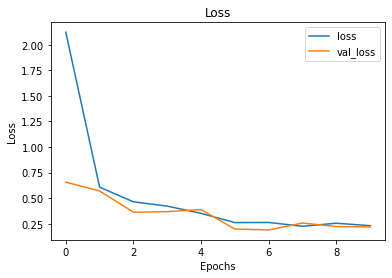

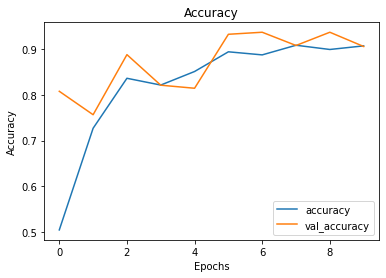

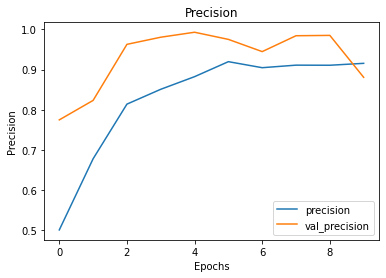

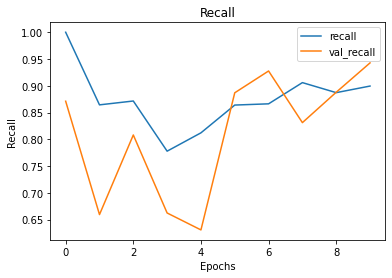

In [53]:
visualize_training_results(cnn_history)

In [54]:
# Print the loss and accuracy for the training set 
cnn_results_train = cnn_model.evaluate(train_generator)
cnn_results_train

35/35 [==============================] - 28s 813ms/step - loss: 0.2560 - accuracy: 0.8954 - precision: 0.8516 - recall: 0.9576


[0.25597622990608215,
 0.8954012393951416,
 0.8516439199447632,
 0.9576194882392883]

In [55]:
# Print the loss and accuracy for the test set 
cnn_results_test = cnn_model.evaluate(test_generator)
cnn_results_test

8/8 [==============================] - 3s 413ms/step - loss: 0.2020 - accuracy: 0.9051 - precision: 0.8504 - recall: 0.9831


[0.20198602974414825,
 0.905063271522522,
 0.8503649830818176,
 0.9831223487854004]

## Finetune Models

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

### MLP Finetune

In [56]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [57]:
mlp_checkpoint = tf.keras.callbacks.ModelCheckpoint("MLP_Finetune_Checkpoint",
                                                monitor="loss",
                                                save_best_only=True)
mlp_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="loss",
                                                  restore_best_weights=True)

In [58]:
mlp_finetune_history = mlp_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[mlp_checkpoint, mlp_early_stopping]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 32s 939ms/step - loss: 0.3318 - accuracy: 0.8542 - precision: 0.8627 - recall: 0.8419 - val_loss: 0.3409 - val_accuracy: 0.8504 - val_precision: 0.9819 - val_recall: 0.7181
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 31s 922ms/step - loss: 0.3112 - accuracy: 0.8672 - precision: 0.8830 - recall: 0.8469 - val_loss: 0.2282 - val_accuracy: 0.9107 - val_precision: 0.9381 - val_recall: 0.8795
INFO:tensorflow:Assets written to: MLP_Finetune_Checkpoint\assets
Epoch 3/100
34/34 [==============================] - 31s 927ms/step - loss: 0.3705 - accuracy: 0.8417 - precision: 0.8387 - recall: 0.8442 - val_loss: 0.3674 - val_accuracy: 0.8661 - val_precision: 0.9884 - val_recall: 0.7456
Epoch 4/100
34/34 [==============================] - 31s 923ms/step - loss: 0.2926 - accuracy: 0.8760 - precision: 0.8805 - recall: 0.8699 - val_loss: 0.2661 - val_accuracy: 0.8951 - val_pre

In [59]:
loss, acc, precision, recall = mlp_model.evaluate(test_generator)

8/8 [==============================] - 3s 427ms/step - loss: 0.2533 - accuracy: 0.8882 - precision: 0.9220 - recall: 0.8481


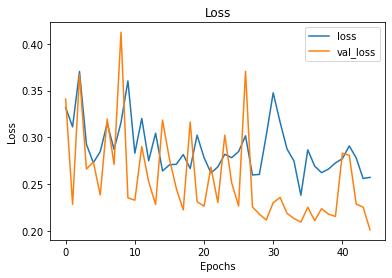

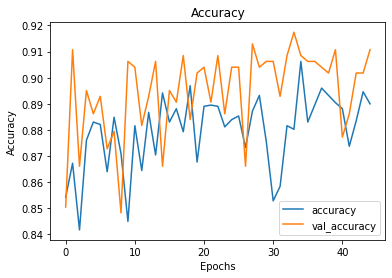

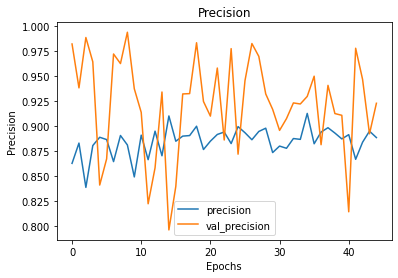

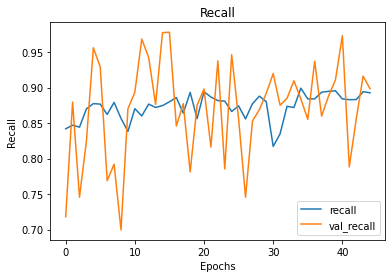

In [60]:
visualize_training_results(mlp_finetune_history)

In [61]:
mlp_results_train = mlp_model.evaluate(train_generator)

35/35 [==============================] - 29s 816ms/step - loss: 0.2485 - accuracy: 0.8968 - precision: 0.9322 - recall: 0.8557


In [62]:
mlp_results_test = mlp_model.evaluate(test_generator)

8/8 [==============================] - 3s 423ms/step - loss: 0.2533 - accuracy: 0.8882 - precision: 0.9220 - recall: 0.8481


### CNN Finetune

In [63]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [64]:
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint("CNN_Finetune_Checkpoint",
                                                monitor="loss",
                                                save_best_only=True)
cnn_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="loss",
                                                  restore_best_weights=True)

In [65]:
cnn_finetune_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    epochs=100,
    validation_data=valid_generator,
    validation_steps = valid_generator.n//valid_generator.batch_size,
    callbacks=[cnn_checkpoint, cnn_early_stopping]
)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 32s 949ms/step - loss: 0.2538 - accuracy: 0.8918 - precision: 0.8938 - recall: 0.8880 - val_loss: 0.2170 - val_accuracy: 0.9375 - val_precision: 0.9852 - val_recall: 0.8889
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 32s 935ms/step - loss: 0.2301 - accuracy: 0.9104 - precision: 0.9311 - recall: 0.8849 - val_loss: 0.1879 - val_accuracy: 0.9308 - val_precision: 0.9289 - val_recall: 0.9330
INFO:tensorflow:Assets written to: CNN_Finetune_Checkpoint\assets
Epoch 3/100
34/34 [==============================] - 32s 931ms/step - loss: 0.2392 - accuracy: 0.9090 - precision: 0.9234 - recall: 0.8907 - val_loss: 0.1997 - val_accuracy: 0.9219 - val_precision: 0.9152 - val_recall: 0.9276
Epoch 4/100
34/34 [==============================] - 32s 933ms/step - loss: 0.2263 - accuracy: 0.9081 - precision: 0.9250 - recall: 0.8870 - val_loss: 0.1759 - val_accuracy: 0.9397 - val_pre

Epoch 34/100
34/34 [==============================] - 31s 915ms/step - loss: 0.1839 - accuracy: 0.9308 - precision: 0.9288 - recall: 0.9331 - val_loss: 0.2132 - val_accuracy: 0.9263 - val_precision: 0.9800 - val_recall: 0.8711
Epoch 35/100
34/34 [==============================] - 31s 924ms/step - loss: 0.1911 - accuracy: 0.9265 - precision: 0.9338 - recall: 0.9183 - val_loss: 0.1793 - val_accuracy: 0.9397 - val_precision: 0.9541 - val_recall: 0.9244
Epoch 36/100
34/34 [==============================] - 31s 915ms/step - loss: 0.1704 - accuracy: 0.9336 - precision: 0.9341 - recall: 0.9332 - val_loss: 0.1652 - val_accuracy: 0.9442 - val_precision: 0.9550 - val_recall: 0.9339
Epoch 37/100
34/34 [==============================] - 31s 912ms/step - loss: 0.1751 - accuracy: 0.9308 - precision: 0.9336 - recall: 0.9276 - val_loss: 0.1808 - val_accuracy: 0.9330 - val_precision: 0.9167 - val_recall: 0.9500
Epoch 38/100
34/34 [==============================] - 31s 915ms/step - loss: 0.1758 - accura

In [66]:
loss, acc, precision, recall = cnn_model.evaluate(test_generator)

8/8 [==============================] - 3s 407ms/step - loss: 0.1398 - accuracy: 0.9409 - precision: 0.9686 - recall: 0.9114


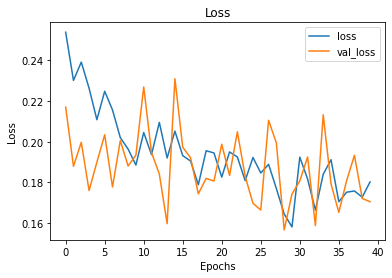

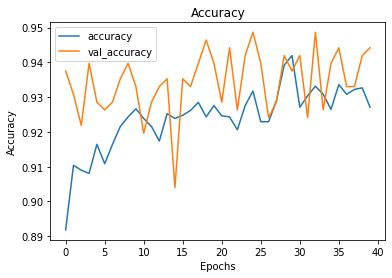

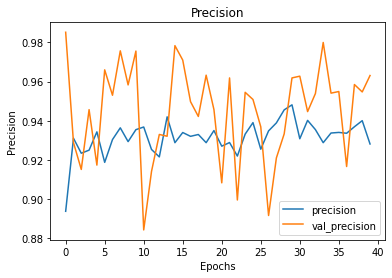

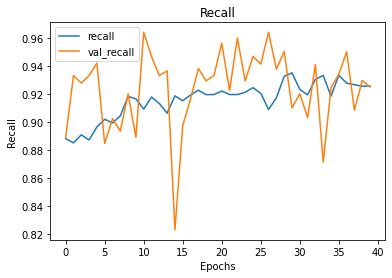

In [67]:
visualize_training_results(cnn_finetune_history)

In [68]:
cnn_results_train = cnn_model.evaluate(train_generator)

35/35 [==============================] - 28s 801ms/step - loss: 0.1679 - accuracy: 0.9297 - precision: 0.9517 - recall: 0.9053


In [69]:
cnn_results_test = cnn_model.evaluate(test_generator)

8/8 [==============================] - 3s 417ms/step - loss: 0.1398 - accuracy: 0.9409 - precision: 0.9686 - recall: 0.9114


## Pretrained Model

In [70]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [71]:
# Initialize Base
pretrain_base = DenseNet201(weights=None,
                 include_top=False,
                 input_shape=(200, 200, 3))

# Define Model Architecture
pretrain_model = keras.Sequential()
pretrain_model.add(pretrain_base)
pretrain_model.add(keras.layers.Flatten())
pretrain_model.add(keras.layers.Dense(64, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(256, activation='relu'))
pretrain_model.add(keras.layers.Dense(128, activation='relu'))
pretrain_model.add(keras.layers.Dense(1, activation='sigmoid'))

pretrain_base.trainable = False

pretrain_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [72]:
pretrain_model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')])

In [73]:
pretrain_model_history = pretrain_model.fit(train_generator,
                                            validation_data = valid_generator,
                                            steps_per_epoch = train_generator.n//train_generator.batch_size,
                                            validation_steps = valid_generator.n//valid_generator.batch_size,
                                            epochs=10)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
34/34 [==============================] - 43s 1s/step - loss: 0.6765 - accuracy: 0.5664 - precision: 0.5784 - recall: 0.4926 - val_loss: 0.5938 - val_accuracy: 0.8527 - val_precision: 0.8465 - val_recall: 0.8616
Epoch 2/10
34/34 [==============================] - 32s 923ms/step - loss: 0.4415 - accuracy: 0.8171 - precision: 0.8558 - recall: 0.7639 - val_loss: 0.2969 - val_accuracy: 0.8795 - val_precision: 0.8523 - val_recall: 0.9140
Epoch 3/10
34/34 [==============================] - 32s 932ms/step - loss: 0.3014 - accuracy: 0.8699 - precision: 0.8749 - recall: 0.8628 - val_loss: 0.3003 - val_accuracy: 0.8527 - val_precision: 0.7955 - val_recall: 0.9459
Epoch 4/10
34/34 [==============================] - 31s 924ms/step - loss: 0.2791 - accuracy: 0.8830 - precision: 0.8876 - recall: 0.8760 - val_loss: 0.2466 - val_accuracy: 0.8973 - val_precision: 0.9450 - val_recall: 0.8438
Epoch 5/10
34/34 [==============================] - 31s 923ms/step - loss: 0.2999 - accuracy: 0.8756 - 

In [116]:
pretrain_model.save("Pretrain_Initial_Model")

INFO:tensorflow:Assets written to: Pretrain_Initial_Model\assets


In [74]:
loss, acc, precision, recall = pretrain_model.evaluate(train_generator)

35/35 [==============================] - 28s 807ms/step - loss: 0.2075 - accuracy: 0.9103 - precision: 0.9487 - recall: 0.8674


In [75]:
loss, acc, precision, recall = pretrain_model.evaluate(test_generator)

8/8 [==============================] - 5s 677ms/step - loss: 0.2157 - accuracy: 0.9093 - precision: 0.9709 - recall: 0.8439


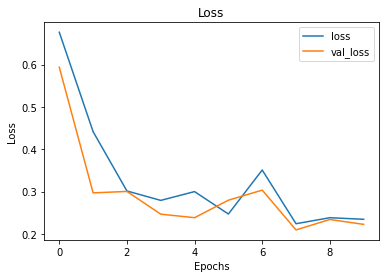

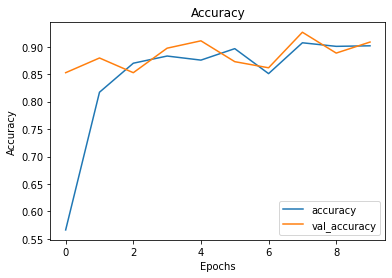

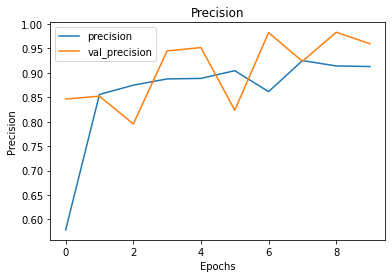

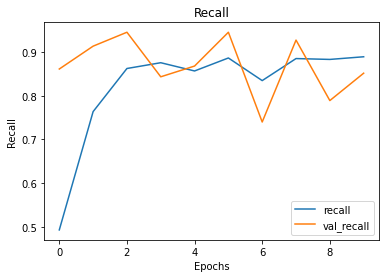

In [76]:
visualize_training_results(pretrain_model_history)

In [77]:
pretrain_results_train = pretrain_model.evaluate(train_generator)
pretrain_results_train

35/35 [==============================] - 29s 809ms/step - loss: 0.2131 - accuracy: 0.9130 - precision: 0.9490 - recall: 0.8729


[0.21313008666038513,
 0.9129846692085266,
 0.9490196108818054,
 0.8728584051132202]

In [78]:
pretrain_results_test = pretrain_model.evaluate(test_generator)
pretrain_results_test

8/8 [==============================] - 3s 409ms/step - loss: 0.2157 - accuracy: 0.9093 - precision: 0.9709 - recall: 0.8439


[0.21574679017066956,
 0.9092826843261719,
 0.9708737730979919,
 0.8438818454742432]

## Finetune Pretrain

In [79]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [80]:
pretrain_model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Finetune_Pretrain_Checkpoint",
                                                               monitor="loss",
                                                               save_best_only=True)
pretrain_model_early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                                 monitor="loss",
                                                                 restore_best_weights=True)

In [81]:
# Initialize Base
finetune_pretrain_base = DenseNet201(weights=None,
                                     include_top=False,
                                     input_shape=(200, 200, 3))

# Define Model Architecture
finetune_pretrain_base = keras.Sequential()
finetune_pretrain_base.add(pretrain_base)
finetune_pretrain_base.add(keras.layers.Flatten())
finetune_pretrain_base.add(keras.layers.Dense(64, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(256, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(128, activation='relu'))
finetune_pretrain_base.add(keras.layers.Dense(1, activation='sigmoid'))

finetune_pretrain_base.trainable = False

finetune_pretrain_base.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 6, 6, 1920)        18321984  
_________________________________________________________________
flatten_3 (Flatten)          (None, 69120)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4423744   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [82]:
finetune_pretrain_base.compile(loss="binary_crossentropy",
                               optimizer="adam",
                               metrics=['accuracy',
                                        tf.keras.metrics.Precision(name='precision'),
                                        tf.keras.metrics.Recall(name='recall')])

In [83]:
finetune_pretrain_model_history = pretrain_model.fit(train_generator,
                                                     validation_data = valid_generator,
                                                     steps_per_epoch = train_generator.n//train_generator.batch_size,
                                                     validation_steps = valid_generator.n//valid_generator.batch_size,
                                                     callbacks=[pretrain_model_checkpoint, pretrain_model_early_stopping],
                                                     epochs=100)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/100
34/34 [==============================] - 32s 938ms/step - loss: 0.2082 - accuracy: 0.9215 - precision: 0.9321 - recall: 0.9087 - val_loss: 0.2407 - val_accuracy: 0.8906 - val_precision: 0.9777 - val_recall: 0.7955
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 2/100
34/34 [==============================] - 33s 960ms/step - loss: 0.2146 - accuracy: 0.9109 - precision: 0.9187 - recall: 0.8997 - val_loss: 0.2066 - val_accuracy: 0.9308 - val_precision: 0.9364 - val_recall: 0.9238
Epoch 3/100
34/34 [==============================] - 33s 961ms/step - loss: 0.2792 - accuracy: 0.8798 - precision: 0.8911 - recall: 0.8655 - val_loss: 0.2595 - val_accuracy: 0.8884 - val_precision: 0.9783 - val_recall: 0.7965
Epoch 4/100
34/34 [==============================] - 33s 958ms/step - loss: 0.2335 - accuracy: 0.9030 - precision: 0.9269 - recall: 0.8742 - val_loss: 0.2220 - val_accuracy: 0.9107 - val_precision: 0.9515 - val_recall: 0.8673
Epoch 5/100
34/34 [======

Epoch 36/100
34/34 [==============================] - 40s 1s/step - loss: 0.1773 - accuracy: 0.9327 - precision: 0.9387 - recall: 0.9256 - val_loss: 0.2051 - val_accuracy: 0.9286 - val_precision: 0.9754 - val_recall: 0.8800
Epoch 37/100
34/34 [==============================] - 40s 1s/step - loss: 0.1578 - accuracy: 0.9364 - precision: 0.9402 - recall: 0.9324 - val_loss: 0.1928 - val_accuracy: 0.9353 - val_precision: 0.9619 - val_recall: 0.9058
INFO:tensorflow:Assets written to: Finetune_Pretrain_Checkpoint\assets
Epoch 38/100
34/34 [==============================] - 40s 1s/step - loss: 0.1811 - accuracy: 0.9336 - precision: 0.9373 - recall: 0.9295 - val_loss: 0.2207 - val_accuracy: 0.9174 - val_precision: 0.9800 - val_recall: 0.8559
Epoch 39/100
34/34 [==============================] - 40s 1s/step - loss: 0.1888 - accuracy: 0.9285 - precision: 0.9347 - recall: 0.9227 - val_loss: 0.1805 - val_accuracy: 0.9375 - val_precision: 0.9181 - val_recall: 0.9595
Epoch 40/100
34/34 [=============

In [113]:
pretrain_model.save("Pretrain_Finetune_Model")

INFO:tensorflow:Assets written to: Pretrain_Finetune_Model\assets


In [84]:
loss, acc, precision, recall = pretrain_model.evaluate(train_generator)

35/35 [==============================] - 37s 1s/step - loss: 0.1522 - accuracy: 0.9337 - precision: 0.9381 - recall: 0.9288


In [85]:
loss, acc, precision, recall = pretrain_model.evaluate(test_generator)

8/8 [==============================] - 5s 556ms/step - loss: 0.1530 - accuracy: 0.9388 - precision: 0.9815 - recall: 0.8945


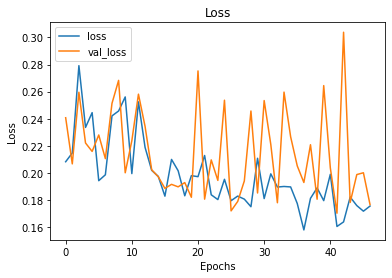

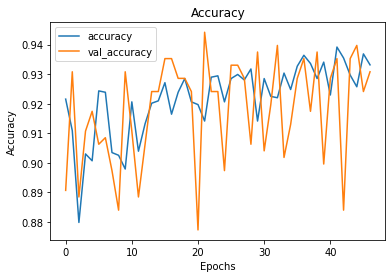

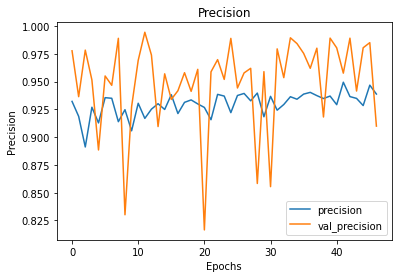

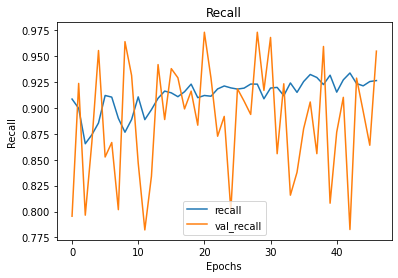

In [86]:
visualize_training_results(finetune_pretrain_model_history)

In [87]:
finetune_pretrain_dict = finetune_pretrain_model_history.history
finetune_pretrain_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [88]:
finetune_pretrain_results_train = pretrain_model.evaluate(train_generator)
finetune_pretrain_results_train

35/35 [==============================] - 37s 1s/step - loss: 0.1599 - accuracy: 0.9391 - precision: 0.9468 - recall: 0.9306


[0.15986071527004242,
 0.9391343593597412,
 0.9467889666557312,
 0.9305680990219116]

In [89]:
finetune_pretrain_results_test = pretrain_model.evaluate(test_generator)
finetune_pretrain_results_test

8/8 [==============================] - 5s 556ms/step - loss: 0.1530 - accuracy: 0.9388 - precision: 0.9815 - recall: 0.8945


[0.15299274027347565,
 0.9388185739517212,
 0.9814814925193787,
 0.8945147395133972]

## Input Test

In [117]:
mlp_original_model = keras.models.load_model('MLP_Initial_Model')

In [118]:
scores = mlp_original_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 5s 562ms/step - loss: 0.2532 - accuracy: 0.8966 - precision: 0.8884 - recall: 0.9072
Loss of the model: 0.25
Test Accuracy: 89.66%


In [119]:
mlp_finetune_model = keras.models.load_model('MLP_Finetune_Checkpoint')

In [120]:
scores = mlp_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 5s 559ms/step - loss: 0.2533 - accuracy: 0.8882 - precision: 0.9220 - recall: 0.8481
Loss of the model: 0.25
Test Accuracy: 88.82%


In [121]:
cnn_initial_model = keras.models.load_model('CNN_Initial_Model')

In [122]:
scores = cnn_initial_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 5s 570ms/step - loss: 0.2020 - accuracy: 0.9051 - precision: 0.8504 - recall: 0.9831
Loss of the model: 0.20
Test Accuracy: 90.51%


In [123]:
cnn_finetune_model = keras.models.load_model('CNN_Finetune_Checkpoint')

In [124]:
scores = cnn_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 5s 584ms/step - loss: 0.1398 - accuracy: 0.9409 - precision: 0.9686 - recall: 0.9114
Loss of the model: 0.14
Test Accuracy: 94.09%


In [125]:
pretrain_model = keras.models.load_model('Pretrain_Initial_Model')

In [126]:
scores = pretrain_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 7s 581ms/step - loss: 0.1530 - accuracy: 0.9388 - precision: 0.9815 - recall: 0.8945
Loss of the model: 0.15
Test Accuracy: 93.88%


In [127]:
pretrain_finetune_model = keras.models.load_model('Pretrain_Finetune_Model')

In [128]:
scores = pretrain_finetune_model.evaluate(test_generator)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

8/8 [==============================] - 7s 600ms/step - loss: 0.1530 - accuracy: 0.9388 - precision: 0.9815 - recall: 0.8945
Loss of the model: 0.15
Test Accuracy: 93.88%


In [129]:
notebook_end = datetime.datetime.now()
notebook_elapsed = notebook_end - notebook_original_start
print('Notebook took a total of {}'.format(elapsed))

Notebook took a total of 0:35:48.627331
